In [1]:
using TVC, DifferentialEquations, Plots, LinearAlgebra

# Specify Parameters

In [2]:
veh = RocketParameters()
atmos = Atmosphere()
traj = RocketTrajectoryParameters();

mdl = RocketProblem(veh, atmos, traj)

RocketProblem
  veh: RocketParameters{Float64, Diagonal{Float64, Vector{Float64}}}
  atmos: Atmosphere
  traj: RocketTrajectoryParameters{Float64}


In [3]:
servoΔt = 0.02 # Servo step rate
x₀ = [[0; 0; 0]; [0; 0; 0]; [1; 0; 0; 0]; [0; 1; 0]][[veh.id_r; veh.id_v; veh.id_quat; veh.id_ω]];

# Specify Controller

## PID Controller

In [4]:
function control(x, p, t)
    veh = p.veh
    tₘ = motorTime(t, p.MotorIgnitionTime)

    desired_torque = -.5 * x[veh.id_quat[2:4]] - .5 * x[veh.id_ω] # PD controller, not well tuned.

    return desired_torque
end

control (generic function with 1 method)

# Continuous Actuator Model

In [5]:
function Actuator(x, p, t, desired_torque) # Model of TVC
    veh = p.veh
    tₘ = motorTime(t, p.MotorIgnitionTime)

    Thrustxy = [0 1; -1 0] * desired_torque[1:2] / veh.MomentArm(tₘ)[3];
    # r \times Thrust = Mb, if r = [0; 0; z] then Thrust = (Mb(2) / z, - Mb(1) / z, 0), then we add in z component of Thrust
    # (Mb(2) / z, - Mb(1) / z) = [0 1; -1 0] * Mb / z
    # See StateSpaceController.m for context

    if veh.Thrust(tₘ) ≈ 0
        Thrust = zeros(3)
    else
        if norm(Thrustxy) < veh.Thrust(tₘ) * sind(5)
            Thrustz = sqrt(veh.Thrust(tₘ)^2 - norm(Thrustxy)^2);
            Thrust = [Thrustxy; Thrustz]
        else 
            Thrustxy = normalize(Thrustxy) * veh.Thrust(tₘ) * sind(5)
            Thrustz = veh.Thrust(tₘ) * cosd(5)
            Thrust = [Thrustxy; Thrustz]
        end
    end

    roll = clamp(desired_torque[3], -.1, .1)
    torque = veh.MomentArm(tₘ) × Thrust + [0; 0; roll]
    
    return (force=Thrust, torque=torque)
end

Actuator (generic function with 1 method)

# Solve ODE

In [6]:
tspan = (0, veh.BurnTime)
p = (veh=veh, atmos=atmos, Aero=true, wind=zeros(3), MotorIgnitionTime=0., Control=(x, p, t) -> Actuator(x, p, t, control(x, p, t)))

prob = ODEProblem(f!, x₀, tspan, p)

condition(x,t,integrator) = x[3] # when height is zero halt integration
cb = ContinuousCallback(condition, nothing, terminate!) # when going upwards do nothing

sol = DifferentialEquations.solve(prob, reltol=1e-8, abstol=1e-8, callback=cb)

retcode: Success
Interpolation: specialized 7th order lazy interpolation, specialized 3rd order "free" stiffness-aware interpolation
t: 345-element Vector{Float64}:
 0.0
 0.049431095882260884
 0.09326440983911899
 0.1348731652251559
 0.17309184002710004
 0.18266001971511278
 0.2032855145537275
 0.20600175793857503
 0.20809964448553755
 0.20898283481959268
 ⋮
 3.4235866684019878
 3.4252011404755898
 3.4260827702245518
 3.4272013983436134
 3.4279452675858395
 3.4353839600081018
 3.439859236349751
 3.445584163306771
 3.45
u: 345-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9996945863924964, 0.0, 0.024713031735009477, 0.0, 0.0, 1.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9989129157479815, 0.0, 0.04661530598275835, 0.0, 0.0, 1.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9977270152616773, 0.0, 0.06738548075828216, 0.0, 0.0, 1.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9962572389076135, 0.0, 0.08643791948085

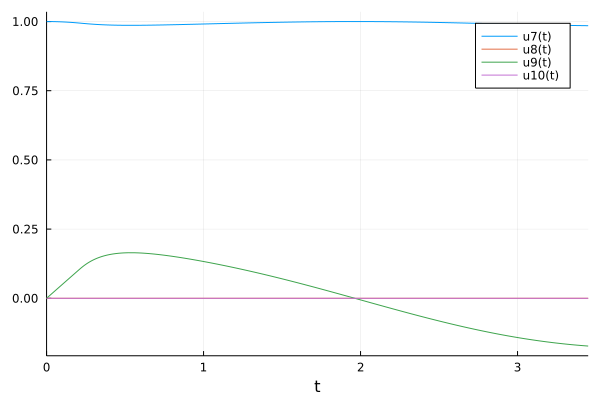

In [7]:
# plot(sol, vars=veh.id_r)
plot(sol, vars=veh.id_quat)
# plot(sol, vars=veh.id_ω)

# deviationAngle = map(q -> acosd(TVC.Utils.rotate(q, [0; 0; 1]) ⋅ [0; 0; 1]), eachcol(sol[veh.id_quat, :]))

# plot(sol.t, deviationAngle)